In [73]:
import torch
import math

from transformers import GPT2Tokenizer, GPT2LMHeadModel, set_seed, AutoModel, AutoConfig, AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import numpy as np
import torch.nn.functional as F

from torch.utils.data import DataLoader

import json
from datasets import load_dataset, load_from_disk
import os
from tqdm import tqdm

import pickle
from modular_transformers.straightening.straightening_utils import compute_model_activations, compute_model_curvature
from modular_transformers.models.gpt2.configuration_gpt2 import GPT2Config

from modular_transformers.models import components

from matplotlib import pyplot as plt
# import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix


#set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#set tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

dir_path = "/om2/user/jackking/modular_transformers/scripts/new_project"

batch_size = 50
num_samples = 5000

In [74]:
def random_perturbation(size):
    def hook(input, hook):
        noise = torch.randn_like(input)
        input_norm = torch.norm(input, dim=-1, keepdim=True)
        noise = noise / torch.norm(noise, dim=-1, keepdim=True) * input_norm * size
        input = input + noise
        return input
    return hook

perturbation_functions_dict = {
    "random": random_perturbation,
}

def get_data(data_type):
    if data_type == "ud":
        data_dir = "/rdma/vast-rdma/vast/evlab/ehoseini/MyData/sent_sampling/analysis/straightening/generation/sentences_ud_sentencez_token_filter_v3_textNoPeriod_cntx_3_cont_7.pkl"
        with open(data_dir, 'rb') as f:
            data = pickle.load(f)
        tokenizer.pad_token = tokenizer.eos_token
        data = tokenizer.batch_encode_plus(data, add_special_tokens=True, padding='longest', return_tensors="pt")["input_ids"]  
        data = data[:, :10].to(device)
        data = data[:num_samples]
    return data

def add_hooks(model, perturbation_function, perturbation_location, size):
    if perturbation_function == "none":
        return
    perturbation_function = perturbation_functions_dict[perturbation_function]
    model.add_perma_hook(name=perturbation_location, hook=perturbation_function(size))
    return model

In [75]:
def compare_distributions(hooked_model, model_name, data):
    regular_model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
    regular_model.eval()
    KLs = []

    for batch_idx in range(0, num_samples, batch_size):
        input = data[batch_idx:batch_idx+batch_size]
        hooked_logits = hooked_model(input)[:, -1, :]
        regular_logits = regular_model(input)[0][:, -1, :]
        for i in range(input.shape[0]):
            indices = torch.sort(regular_logits[i])[1][-10:]
            hooked_dist = F.softmax(hooked_logits[i][indices], dim=-1)
            regular_dist = F.softmax(regular_logits[i][indices], dim=-1)
            KL = sum([hooked_dist[j] * torch.log(hooked_dist[j] / regular_dist[j]) for j in range(len(hooked_dist))]).item()
            KLs.append(KL)
    return np.array(KLs)


In [76]:
data_type = "ud"
data = get_data(data_type)
model_name = "gpt2-xl"
model = HookedTransformer.from_pretrained(model_name).to(device)
model.eval()
perturbation_type = "random"
perturbation_size = 1
layer = 30
perturbation_location = f"blocks.{layer}.hook_resid_post"
model = add_hooks(model, perturbation_type, perturbation_location, perturbation_size)

Loaded pretrained model gpt2-xl into HookedTransformer
Moving model to device:  cuda


In [77]:
KLs = compare_distributions(model, model_name, data)

In [78]:
curve_model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
activations = compute_model_activations(curve_model, data, device)
curvature = compute_model_curvature(activations)

  0%|          | 0/5000 [00:00<?, ?it/s]/net/vast-storage/scratch/vast/evlab/jackking/modular_transformers/modular_transformers/straightening/straightening_utils.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens_tensor = torch.tensor(indexed_tokens[i]).to(device)
100%|██████████| 5000/5000 [02:03<00:00, 40.40it/s]
5000it [00:52, 94.72it/s]


R^2: 0.0016276066472563837


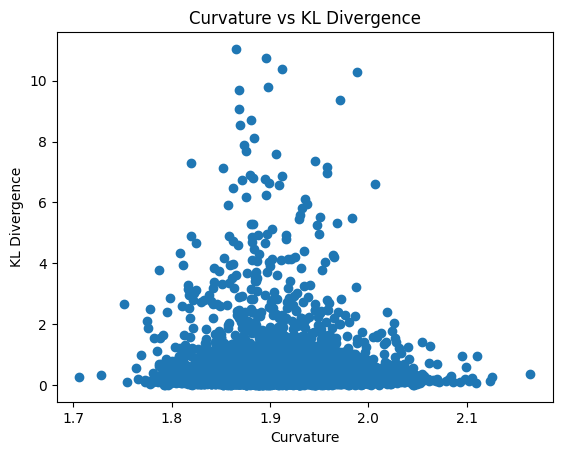

In [79]:
plt.scatter(curvature["curve"][layer], KLs)
plt.xlabel("Curvature")
plt.ylabel("KL Divergence")
plt.title("Curvature vs KL Divergence")
r2 = np.corrcoef(curvature["curve"][layer], KLs)[0, 1] ** 2
print(f"R^2: {r2}")
plt.show()